In [1]:
# importing utilities
import os
import sys
from datetime import datetime

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

# importing pytorch libraries
import torch
from torch import nn
from torch import autograd
from torch.utils.data import DataLoader

# import visualization libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
# from IPython.display import Image, display
# sns.set_style('darkgrid')

# ignore potential warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
USE_MPS = True

In [3]:
# load the dataset into the notebook kernel
ori_dataset = pd.read_parquet('./data/input.parquet')

In [4]:
# inspect the datasets dimensionalities
now = datetime.now().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] Transactional dataset of {} rows and {} columns loaded'.format(now, ori_dataset.shape[0], ori_dataset.shape[1]))

[LOG 20240712-16:39:11] Transactional dataset of 2107826 rows and 10 columns loaded


In [5]:
# inspect top rows of dataset
ori_dataset.head(10) 

,BELNR,BSCHL,BUKRS,YEAR,HKONT_grouping,HKONT,WAERS,HKONT_text,WRBTR,DMBTR
0,100000000,50,IBE,2023,unlabelled,1143733,CHF,<NA>,0.00,0.01
1,100000000,40,IBE,2023,running_costs,6045011,CHF,Foreign exchange losses,0.00,0.01
2,100000002,40,IBE,2023,unlabelled,1143731,USD,<NA>,9586.94,9586.94
3,100000002,50,IBE,2023,unlabelled,1143731,USD,<NA>,9586.94,9586.94
4,100000010,40,IBE,2023,unlabelled,1143731,USD,<NA>,11584.66,11584.66
5,100000010,50,IBE,2023,unlabelled,1143731,USD,<NA>,11584.66,11584.66
6,100000011,40,IBE,2023,unlabelled,1143733,CHF,<NA>,0.00,35.27
7,100000011,50,IBE,2023,running_costs,7045011,CHF,Foreign exchange gains,0.00,35.27
8,100000013,40,IBE,2023,unlabelled,1143733,CHF,<NA>,0.00,1.02
9,100000013,50,IBE,2023,running_costs,7045011,CHF,Foreign exchange gains,0.00,1.02


Text(0.5, 1.0, 'Distribution of HKONT attribute values')

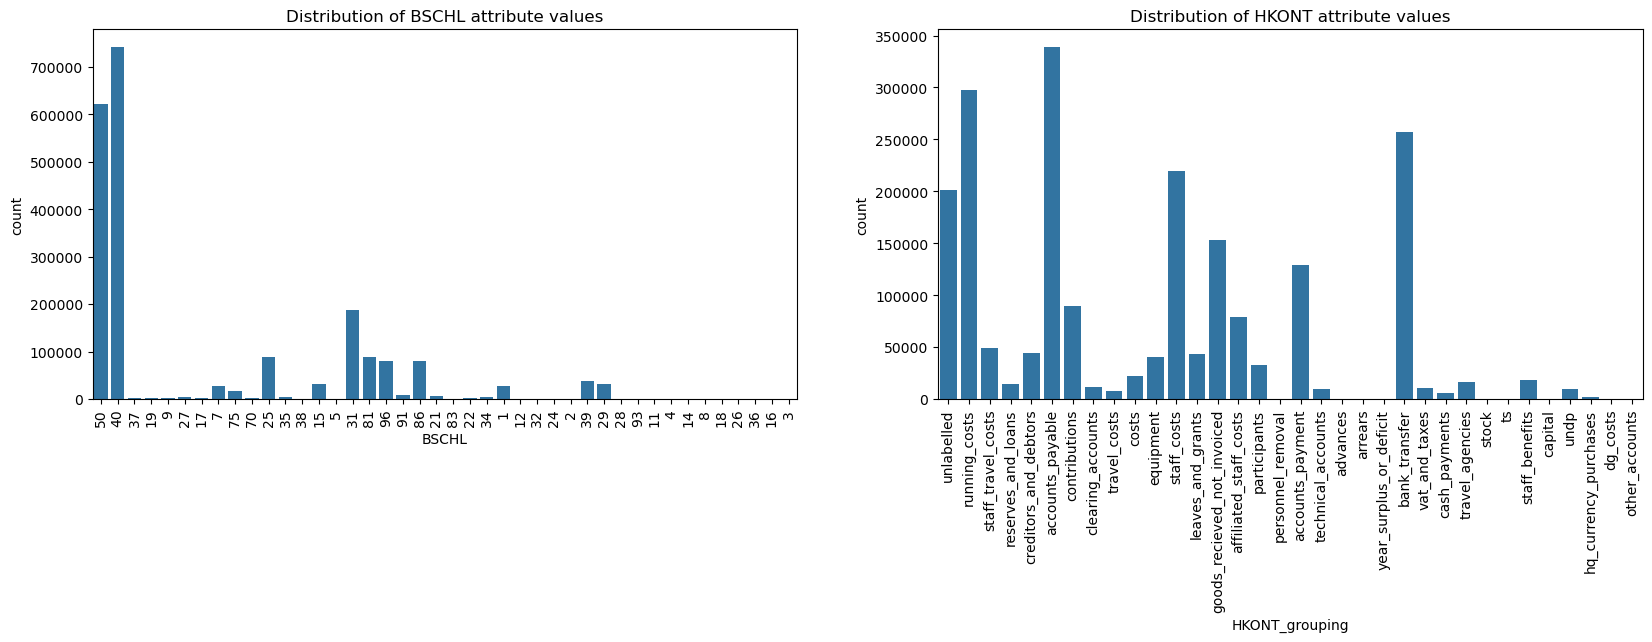

In [6]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot the distribution of the posting key attribute
g = sns.countplot(x=ori_dataset['BSCHL'], ax=ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Distribution of BSCHL attribute values')

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=ori_dataset['HKONT_grouping'], ax=ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Distribution of HKONT attribute values')

In [7]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['BUKRS', 'BSCHL','HKONT_grouping','WAERS']

# encode categorical attributes into a binary one-hot encoded representation 
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])

### 3.2 Pre-Processing of Numerical Transaction Attributes

Let's now inspect the distributions of the two numerical attributes contained in the transactional dataset namely, the (1) local currency amount `DMBTR` and the (2) document currency amount `WRBTR`:

Text(0.5, 1.0, 'Distribution of WRBTR amount values')

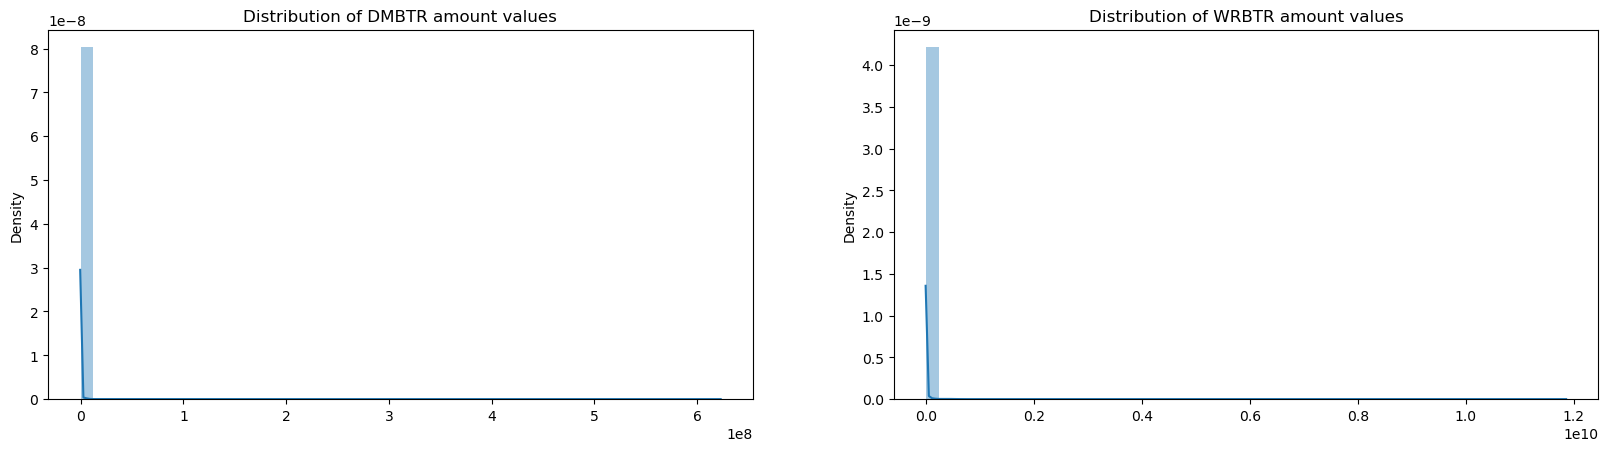

In [8]:
# plot the log-scaled "DMBTR" as well as the "WRBTR" attribute value distribution
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

head = 1000000

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset.sample(head)['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of DMBTR amount values')

# plot distribution of the document amount attribute
g = sns.distplot(ori_dataset.sample(head)['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of WRBTR amount values')

As expected, it can be observed, that for both attributes the distributions of amount values are heavy tailed. In order to approach faster a potential global minimum scaling and normalization of numerical input values is good a practice. Therefore, we first log-scale both variables and second min-max normalize the scaled amounts to the interval [0, 1].

In [9]:
# select "DMBTR" vs. "WRBTR" attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-7
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

### 3.3 Merge Categorical and Numerical Transaction Attributes

In [10]:
# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr], axis = 1)

In [18]:
for c, d in zip(ori_subset_transformed.columns,ori_subset_transformed.dtypes):
    if d == 'bool' or d == 'boolean':
        ori_subset_transformed[c] = ori_subset_transformed[c].astype('int8')

In [19]:
# define the optimization criterion / loss function
loss_function = nn.BCEWithLogitsLoss(reduction='mean')

In [20]:
num_epochs = 5
mini_batch_size = 128

In [23]:
# convert pre-processed data to pytorch tensor
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

# convert to pytorch tensor - none cuda enabled
dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=0)

In [24]:
# implementation of the encoder network
class encoder(nn.Module):

    def __init__(self):

        super(encoder, self).__init__()

        # specify layer 1 - in 618, out 512
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=512, bias=True) # add linearity 
        nn.init.xavier_uniform_(self.encoder_L1.weight) # init weights according to [9]
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify layer 2 - in 512, out 256
        self.encoder_L2 = nn.Linear(512, 256, bias=True)
        nn.init.xavier_uniform_(self.encoder_L2.weight)
        self.encoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 256, out 128
        self.encoder_L3 = nn.Linear(256, 128, bias=True)
        nn.init.xavier_uniform_(self.encoder_L3.weight)
        self.encoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 128, out 64
        self.encoder_L4 = nn.Linear(128, 64, bias=True)
        nn.init.xavier_uniform_(self.encoder_L4.weight)
        self.encoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 64, out 32
        self.encoder_L5 = nn.Linear(64, 32, bias=True)
        nn.init.xavier_uniform_(self.encoder_L5.weight)
        self.encoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 32, out 16
        self.encoder_L6 = nn.Linear(32, 16, bias=True)
        nn.init.xavier_uniform_(self.encoder_L6.weight)
        self.encoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 7 - in 16, out 8
        self.encoder_L7 = nn.Linear(16, 8, bias=True)
        nn.init.xavier_uniform_(self.encoder_L7.weight)
        self.encoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 8, out 4
        self.encoder_L8 = nn.Linear(8, 4, bias=True)
        nn.init.xavier_uniform_(self.encoder_L8.weight)
        self.encoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 4, out 3
        self.encoder_L9 = nn.Linear(4, 3, bias=True)
        nn.init.xavier_uniform_(self.encoder_L9.weight)
        self.encoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)
        
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.dropout(self.encoder_L1(x)))
        x = self.encoder_R2(self.dropout(self.encoder_L2(x)))
        x = self.encoder_R3(self.dropout(self.encoder_L3(x)))
        x = self.encoder_R4(self.dropout(self.encoder_L4(x)))
        x = self.encoder_R5(self.dropout(self.encoder_L5(x)))
        x = self.encoder_R6(self.dropout(self.encoder_L6(x)))
        x = self.encoder_R7(self.dropout(self.encoder_L7(x)))
        x = self.encoder_R8(self.dropout(self.encoder_L8(x)))
        x = self.encoder_R9(self.encoder_L9(x)) # don't apply dropout to the AE bottleneck

        return x

In [25]:
# implementation of the decoder network
class decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()

        # specify layer 1 - in 3, out 4
        self.decoder_L1 = nn.Linear(in_features=3, out_features=4, bias=True) # add linearity 
        nn.init.xavier_uniform_(self.decoder_L1.weight)  # init weights according to [9]
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify layer 2 - in 4, out 8
        self.decoder_L2 = nn.Linear(4, 8, bias=True)
        nn.init.xavier_uniform_(self.decoder_L2.weight)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 8, out 16
        self.decoder_L3 = nn.Linear(8, 16, bias=True)
        nn.init.xavier_uniform_(self.decoder_L3.weight)
        self.decoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 16, out 32
        self.decoder_L4 = nn.Linear(16, 32, bias=True)
        nn.init.xavier_uniform_(self.decoder_L4.weight)
        self.decoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 32, out 64
        self.decoder_L5 = nn.Linear(32, 64, bias=True)
        nn.init.xavier_uniform_(self.decoder_L5.weight)
        self.decoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 64, out 128
        self.decoder_L6 = nn.Linear(64, 128, bias=True)
        nn.init.xavier_uniform_(self.decoder_L6.weight)
        self.decoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify layer 7 - in 128, out 256
        self.decoder_L7 = nn.Linear(128, 256, bias=True)
        nn.init.xavier_uniform_(self.decoder_L7.weight)
        self.decoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 256, out 512
        self.decoder_L8 = nn.Linear(256, 512, bias=True)
        nn.init.xavier_uniform_(self.decoder_L8.weight)
        self.decoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 512, out 618
        self.decoder_L9 = nn.Linear(in_features=512, out_features=ori_subset_transformed.shape[1], bias=True)
        nn.init.xavier_uniform_(self.decoder_L9.weight)
        self.decoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)

    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.dropout(self.decoder_L1(x)))
        x = self.decoder_R2(self.dropout(self.decoder_L2(x)))
        x = self.decoder_R3(self.dropout(self.decoder_L3(x)))
        x = self.decoder_R4(self.dropout(self.decoder_L4(x)))
        x = self.decoder_R5(self.dropout(self.decoder_L5(x)))
        x = self.decoder_R6(self.dropout(self.decoder_L6(x)))
        x = self.decoder_R7(self.dropout(self.decoder_L7(x)))
        x = self.decoder_R8(self.dropout(self.decoder_L8(x)))
        x = self.decoder_R9(self.decoder_L9(x)) # don't apply dropout to the AE output
        
        return x

In [26]:
# restore pretrained model checkpoint
encoder_model_name = "ep_5_encoder_model.pth"
decoder_model_name = "ep_5_decoder_model.pth"

# init training network classes / architectures
encoder_eval = encoder()
decoder_eval = decoder()

# load trained models
encoder_eval.load_state_dict(torch.load(os.path.join("models", encoder_model_name)))
decoder_eval.load_state_dict(torch.load(os.path.join("models", decoder_model_name)))

<All keys matched successfully>

### 6.1 Assessment of the Pre-Trained Model

Once obtained, let's use the model to reconstruct the entire dataset:

In [27]:
# convert encoded transactional data to torch Variable
data = autograd.Variable(torch_dataset)

# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# reconstruct encoded transactional data
reconstruction = decoder_eval(encoder_eval(data))

Now, let's assess its quality by calculating the reconstruction error over the entire dataset:

In [28]:
# determine reconstruction loss - all transactions
reconstruction_loss_all = loss_function(reconstruction, data)

# print reconstruction loss - all transactions
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] collected reconstruction loss of: {:06}/{:06} transactions'.format(now, reconstruction.size()[0], reconstruction.size()[0]))
print('[LOG {}] reconstruction loss: {:.10f}'.format(now, reconstruction_loss_all.item()))

[LOG 20240712-14:42:29] collected reconstruction loss of: 2107826/2107826 transactions
[LOG 20240712-14:42:29] reconstruction loss: 0.0077538183


Ok, nice. Comparing the overall reconstruction loss of the pre-trained model trained for **10 epochs** to the one we initially trained for **5 epochs** reveals, that the pre-trained model results in a significantly lower reconstruction error. We can therefore conclude that the pre-trained model outperforms our initial model in capturing the inherent characteristics of the journal entries.

### 6.2 Assessment of the Individual Transactions

Ok, now that we are convinced that the pre-trained model is of decent quality let's assess the individual journal entries of the dataset. To achieve this, we collect the reconstruction errors of each individual journal entry by executing the cell below:

In [29]:
# init binary cross entropy errors
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

# iterate over all detailed reconstructions
for i in range(0, reconstruction.size()[0]):

    # determine reconstruction loss - individual transactions
    reconstruction_loss_transaction[i] = loss_function(reconstruction[i], data[i]).item()

    if(i % 100000 == 0):

        ### print conversion summary
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] collected individual reconstruction loss of: {:06}/{:06} transactions'.format(now, i, reconstruction.size()[0]))
        

[LOG 20240712-14:42:35] collected individual reconstruction loss of: 000000/2107826 transactions
[LOG 20240712-14:42:36] collected individual reconstruction loss of: 100000/2107826 transactions
[LOG 20240712-14:42:37] collected individual reconstruction loss of: 200000/2107826 transactions
[LOG 20240712-14:42:39] collected individual reconstruction loss of: 300000/2107826 transactions
[LOG 20240712-14:42:40] collected individual reconstruction loss of: 400000/2107826 transactions
[LOG 20240712-14:42:42] collected individual reconstruction loss of: 500000/2107826 transactions
[LOG 20240712-14:42:43] collected individual reconstruction loss of: 600000/2107826 transactions
[LOG 20240712-14:42:44] collected individual reconstruction loss of: 700000/2107826 transactions
[LOG 20240712-14:42:46] collected individual reconstruction loss of: 800000/2107826 transactions
[LOG 20240712-14:42:47] collected individual reconstruction loss of: 900000/2107826 transactions
[LOG 20240712-14:42:48] collec

Once we have collected individual reconstruction errors let's visualize them accordingly:

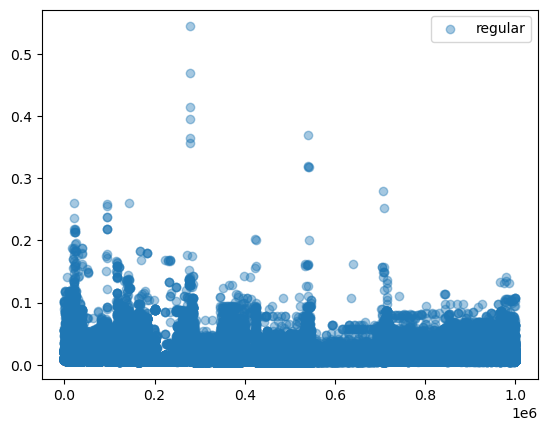

In [30]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# assign unique id to transactions
plot_data = np.column_stack((np.arange(len(reconstruction_loss_transaction)), reconstruction_loss_transaction))
dat = plot_data[:1000000]

# obtain regular transactions as well as global and local anomalies
# regular_data = plot_data[label == 'regular']
# global_outliers = plot_data[label == 'global']
# local_outliers = plot_data[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(dat[:, 0], dat[:, 1], c='C0', alpha=0.4, marker="o", label='regular') # plot regular transactions
# ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="^", label='global') # plot global outliers
# ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C2', marker="^", label='local') # plot local outliers

# add plot legend of transaction classes
ax.legend(loc='best')

The visualization reveals that the pre-trained model is able to reconstruct the majority of regular journal entries, while failing to do so, for the anomalous ones. As a result, the model reconstruction error can be used to distinguish both "global" anomalies (orange) and "local" anomalies (green) from the regular journal entries (blue).

To further investigate our observation and confirm the initial assumption, let's have a closer look into the journal entries exhibiting a "high" binary cross-entropy reconstruction error >= 0.1. We assume that these journal entries correspond to the "global" anomalies of the original dataset:

In [31]:
reconstruction_loss_transaction.mean()

0.007753818699989871

In [98]:
ori_dataset['reconstruction_loss'] = reconstruction_loss_transaction

In [32]:
# append labels to original dataset
# ori_dataset['label'] = label

max_recon = 0.18
min_recon = 0.1
# inspect transactions exhibiting a reconstruction error >= 0.1
ori_dataset[reconstruction_loss_transaction >= max_recon]#.groupby(['BUKRS','HKONT_grouping']).agg(count = ('BUKRS','count'), usd_amount = ('DMBTR','sum'))
# ori_dataset[ori_dataset.BELNR == 8600003414].sort_values('reconstruction_loss')#.groupby(['BUKRS','HKONT_grouping']).agg(count = ('BUKRS','count'), usd_amount = ('DMBTR','sum'))

,BELNR,BSCHL,BUKRS,YEAR,HKONT_grouping,HKONT,WAERS,HKONT_text,WRBTR,DMBTR
17049,9200000095,19,IBE,2023,contributions,2011044,EUR,Re-invoiced costs receivable,350.00,441.36
19584,100000401,40,ICBA,2023,running_costs,6045011,XAF,Foreign exchange losses,0.00,45.34
21186,4500000000,50,ICBA,2023,unlabelled,5098030,EUR,<NA>,626.70,683.42
21493,5000000153,81,ICBA,2023,running_costs,6034029,TZS,Contract for Services,28173913.04,11292.15
21541,5100000003,91,ICBA,2023,running_costs,6034029,KES,Contract for Services,0.00,19.35
21905,5100000137,91,ICBA,2023,running_costs,6034029,TZS,Contract for Services,0.00,31.55
21958,6400000008,25,ICBA,2023,accounts_payable,2021011,KES,Vendors payable,362310.00,2932.50
22080,6400000062,31,ICBA,2023,travel_costs,2021091,ETB,Travel costs reimbursements,57181.80,1056.30
22493,6400000250,50,ICBA,2023,unlabelled,5098030,TZS,<NA>,10001500.00,4008.62
22510,6400000255,50,ICBA,2023,unlabelled,5098030,TZS,<NA>,170000.00,68.14


Let's now also have a closer look into the journal entries exhibiting a "medium" binary cross-entropy reconstruction error >= 0.02 and < 0.1. We assume that these journal entries mostly correspond to the "local" anomalies of the original dataset:

In [33]:
# inspect transactions exhibiting a reconstruction error < 0.1 and >= 0.05
ori_dataset[(reconstruction_loss_transaction >= min_recon) & (reconstruction_loss_transaction < max_recon)]

,BELNR,BSCHL,BUKRS,YEAR,HKONT_grouping,HKONT,WAERS,HKONT_text,WRBTR,DMBTR
106,100000164,9,IBE,2023,unlabelled,2011041,CHF,<NA>,0.00,26.46
110,100000171,9,IBE,2023,unlabelled,2011041,CHF,<NA>,0.00,353.29
175,100000352,9,IBE,2023,unlabelled,2011041,CHF,<NA>,0.00,742.51
230,100000518,9,IBE,2023,unlabelled,2011041,CHF,<NA>,0.00,283.76
270,100000559,9,IBE,2023,unlabelled,2011041,CHF,<NA>,0.00,105.37
...,...,...,...,...,...,...,...,...,...,...
2102776,9300007895,50,UNES,2023,creditors_and_debtors,2086091,MRU,Suspense account for expenses without assignment,14000.00,368.92
2104476,9300008738,50,UNES,2023,creditors_and_debtors,2086091,MWK,Suspense account for expenses without assignment,450000.00,434.26
2104478,9300008739,50,UNES,2023,creditors_and_debtors,2086091,MWK,Suspense account for expenses without assignment,393900.00,370.25
2105537,9500000258,24,UNES,2023,accounts_payable,2021042,CAD,Reimbursement of staff expenses claims,775.65,569.08


## 7. Optional Exercises

Please read ahead and only come back to these optional exercises if time permits.

**1. Train the autoencoder model from scratch** [15 mins]

First, change the number of training epochs `num_epochs` to **30** in the corresponding cell of section 5.1. Second, you might also want to try different learning rates other than the initial learning rate of **0.001** in the corresponding cell of section 4.3. Third, comment out the two lines in the first cell of section 6. where the pre-trained model is defined (under "restore pre-trained model checkpoint") as well as two lines where it is loaded (under "load trained models"). 

Please, note that after altering the number of training epochs in section 5.1 and/or the learning rate in section 4.3 you need to execute all successive cells starting from section 5.1 or 4.3.

**2. What would happen if we remove a few fully-connected layers?** [15 mins]

We designed a specific model for the lab because experiments show that the structure provided result in a good detection accuracy. Let's see how the reconstruction performance change if we would **remove several of the hidden layers**. First, adjust the encoder and decoder model definitions in section 4.2 accordingly (you may want to use the code snippets shown below). Then, follow all the instructions for training from scratch.

Please, note that after altering the encoder and / or decoder network architecture in section 4.2 you need to execute all successive cells starting from section 4.2.

In [ ]:
# implementation of the shallow encoder network 
# containing only a single layer
class shallow_encoder(nn.Module):

    def __init__(self):

        super(encoder, self).__init__()

        # specify layer 1 - in 618, out 3
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=3, bias=True) # add linearity 
        nn.init.xavier_uniform_(self.encoder_L1.weight) # init weights according to [9]
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]
        
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.encoder_L1(x)) # don't apply dropout to the AE bottleneck

        return x

In [ ]:
# implementation of the shallow decoder network 
# containing only a single layer
class shallow_decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()

        # specify layer 1 - in 3, out 618
        self.decoder_L1 = nn.Linear(in_features=3, out_features=ori_subset_transformed.shape[1], bias=True) # add linearity 
        nn.init.xavier_uniform_(self.decoder_L1.weight)  # init weights according to [9]
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.decoder_L1(x)) # don't apply dropout to the AE output
        
        return x

**3. Explore the latent space representation** [15 min]

In a real world scenario it is usually beneficial to visualize the data manifolds to:

> 1. determine if the autoencoder learned a meaningful representation; and,
> 2. obtain an impression of the structural characteristics and dependencies in the data.

To achieve this, we will propagate the data through the trained model and capture for each transaction the respective representation in the latent space as referred to as "embeddings" (the activation pattern of each journal entry at the bottleneck neurons). 

Therefore, we intentionally chose a bottleneck layer comprised of 3 neurons. This provides us the ability to visualize the distinctive activation pattern using the 3d plotting capabilities of Pythons matplotlib library. In the subsequent cells we already prepared a plotting function that draws a 3d scatter plot of the latent space representation of each transaction at a particular epoch.

In [ ]:
# plot latent space representation of all samples given latent variable and label class
def plot_latent_space(latent_variable, label, epoch):
    """ Plots latent space activations as a 3d scatter plot at particular epoch
    :param latent_space: activations of latent space
    :param label: 1-d array of labels defining type of anomaly
    :param epoch: training epoch
    """
    # prepare plot
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(30, 45)

    # set axis paramaters of subplot
    ax.grid(linestyle='dotted')
    
    # set label and title details
    ax.set_xlabel(r'activation [$z_1$]', weight='normal', fontsize=12)
    ax.set_ylabel(r'activation [$z_2$]', weight='normal', fontsize=12)
    ax.set_zlabel(r'activation [$z_3$]', weight='normal', fontsize=12)
    plt.title('latent space activations at epoch ' + str(epoch), fontsize=12)

    # plot regular transactions
    regular = latent_variable[np.where(label == 'regular')]
    ax.scatter(regular[:, 0], regular[:, 1], regular[:, 2], c='C0', alpha=0.4, marker="o")

    # plot first order anomalous transactions
    anomalies_1 = latent_variable[np.where(label == 'global')]
    ax.scatter(anomalies_1[:, 0], anomalies_1[:, 1], anomalies_1[:, 2], c='C1', s=100, marker="^")

    # plot second order anomalous transactions
    anomalies_2 = latent_variable[np.where(label == 'local')]
    ax.scatter(anomalies_2[:, 0], anomalies_2[:, 1], anomalies_2[:, 2], c='C2', s=100, marker="^")

However, before plotting the embeddings we load the model of the shallow autoencoder network you have been asked to train in exercise 7.2 of the optional exercises. Since we are interested on the latent space representation of each transaction we only need to load the pre-trained encoder part of the autoencoder (ignoring the decoder part) and propagate all transactions through it.

The function below will accomplish these steps for a given pre-trained encoder model.

In [ ]:
# extract latent space representation of all samples given the name of encoder model to be loaded
def get_latent_space(encoder_model_name):
    ''' Extracts the latent space representation
    :param encoder_model_name: file name of the pretrained encoder model
    :return: latent space representation
    '''
    # init training network classes / architectures
    encoder_eval = encoder()

    # load trained models
    encoder_eval.load_state_dict(torch.load(os.path.join("models", encoder_model_name)))

    # convert encoded transactional data to torch Variable
    data = autograd.Variable(torch_dataset)

    # set networks in training mode (don't apply dropout)
    encoder_eval.eval()

    # extract encoded latent space representation
    latent_variable = encoder_eval(data).data.numpy()
    
    return latent_variable

Now let's check how the latent space representation "embeddings" of the individual transactions changes with progressing training epochs. In order to do so, you can load any checkpoint of a particular training epoch and visualize the latent representations you want to have a look at using the code snipped below. 

If you didn't find the time to accomplish exercise 7.2 you may want to plot the embeddings using the pre-trained model we prepared for this lab as stated in the cell below. This will also give you an idea of the transactional manifolds learned by the autoencoder network.

In [ ]:
# determine epoch of model to be evaluated
eval_epoch = 5

# collect latent space representation at a certain epochs 
z_representation = get_latent_space(encoder_model_name='ep_{}_encoder_model.pth'.format(eval_epoch))

# plot the latent space at a particular epoch
plot_latent_space(z_representation, label, epoch=eval_epoch)